# Exploratory Data Analysis with Delphes Data

This notebook demonstrates how to load and explore your Delphes data using [`coffea`](https://coffea-hep.readthedocs.io/en/latest/). It uses `uproot` behind the scenes to read ROOT files and the scheme tailored to the Delphes output.

Later, you can extend this notebook for more advanced statistical analyses or machine learning training for signal discrimination.

In [2]:
#!/usr/bin/env python
import matplotlib.pyplot as plt
import mplhep as hep
import awkward as ak
import numpy as np
from coffea.nanoevents import NanoEventsFactory, DelphesSchema
import hist
import vector

/Users/pgadow/Coding/uhh/pheno/pheno_h2zllahad/micromamba/envs/micromamba_h2zllahad/lib/python3.9/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


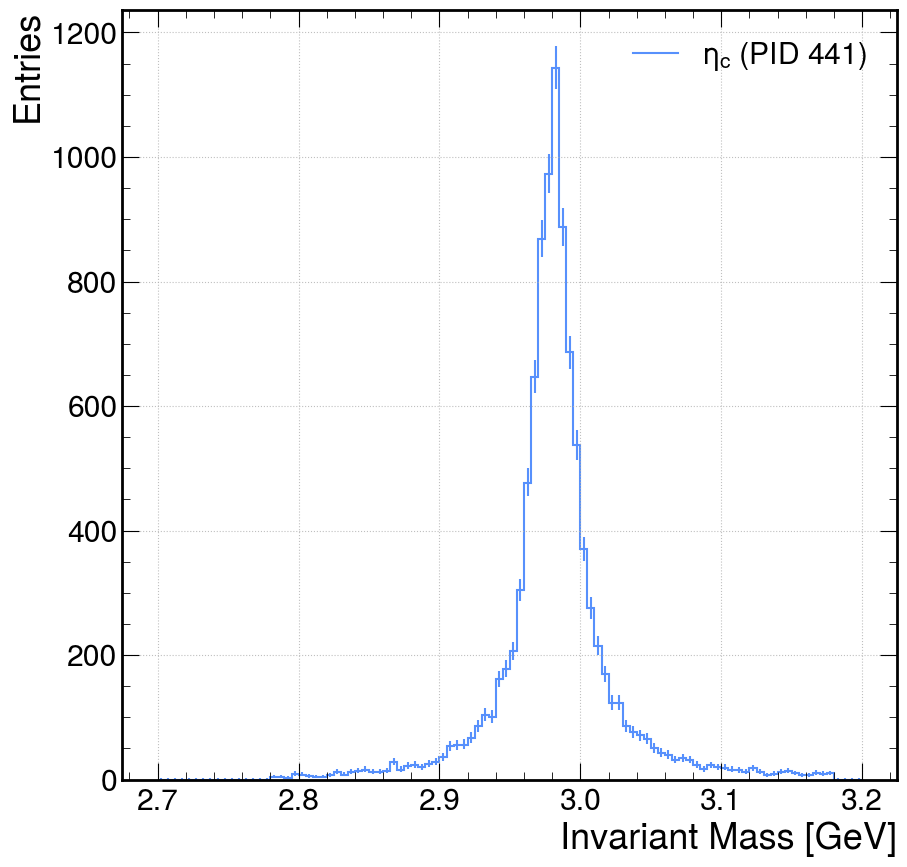

In [7]:

# Analysis of H -> Z eta_c
filename = "../output/ggH_2HDM/delphes_output_HZetac.root"

# Create a NanoEvents object using the Delphes schema.
# This automatically interprets the ROOT file structure as defined by Delphes.
events = NanoEventsFactory.from_root(filename, schemaclass=DelphesSchema).events()

# Access the Particle collection and restrict to particles with PID 441 (eta_c meson).
particles = events.Particle
particles_pid441 = particles[particles.PID == 441]

# Compute the invariant mass for each particle and convert awkward array to a flat numpy array
mass_pid441 = particles_pid441.mass.compute()
mass_pid441 = ak.flatten(mass_pid441).to_numpy()

# Create a histogram object and fill it with the mass data
h = hist.Hist(
    hist.axis.Regular(100, 2.7, 3.2, name="Invariant Mass [GeV]", label='$\eta_{c}$ (PID 441)')
)
h.fill(mass_pid441)

# Plot the invariant mass distribution using matplotlib and CMS style
hep.style.use(hep.style.CMS)
fig, ax = plt.subplots()
h.plot(ax=ax, histtype='step')
ax.legend([r'$\eta_{c}$ (PID 441)'])
ax.set_xlabel('Invariant Mass [GeV]')
ax.set_ylabel('Entries')
ax.grid(True)
plt.show()

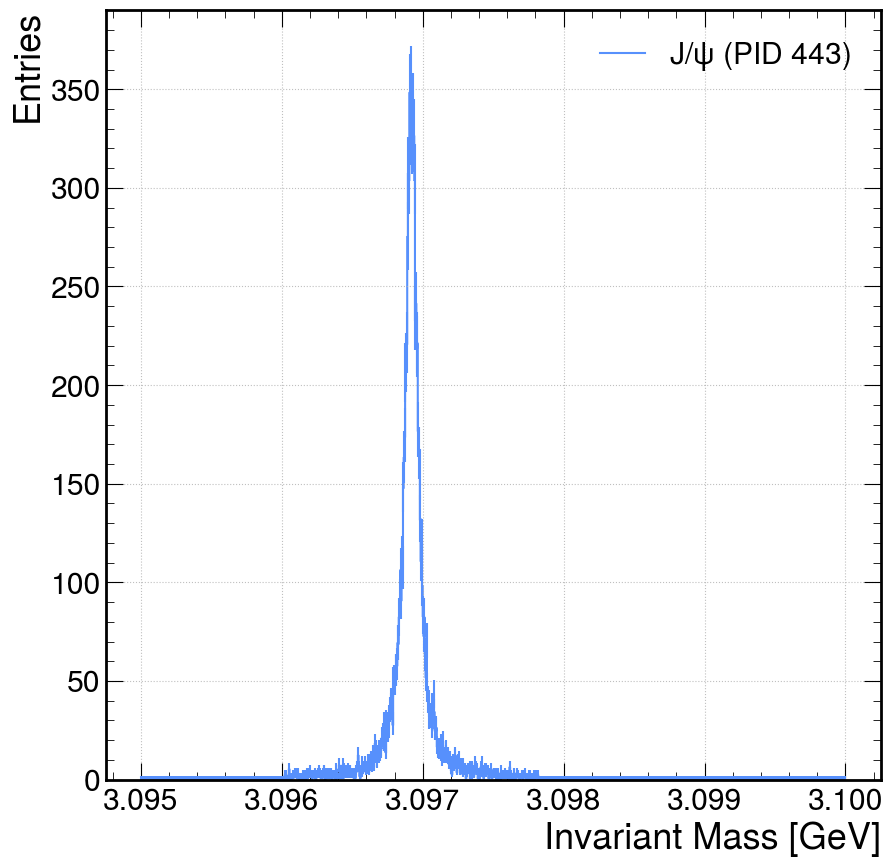

In [8]:
# Analysis of H -> Z J/Psi
filename = "../output/ggH_2HDM/delphes_output_HZJpsi.root"

# Create a NanoEvents object using the Delphes schema.
# This automatically interprets the ROOT file structure as defined by Delphes.
events = NanoEventsFactory.from_root(filename, schemaclass=DelphesSchema).events()

# Access the Particle collection and restrict to particles with PID 443 (J/Psi meson).
particles = events.Particle
particles_pid443 = particles[particles.PID == 443]

# Compute the invariant mass for each particle and convert awkward array to a flat numpy array
mass_pid443 = particles_pid443.mass.compute()
mass_pid443 = ak.flatten(mass_pid443, axis=-1).to_numpy()

# Create a histogram object and fill it with the mass data
h = hist.Hist(
    hist.axis.Regular(1000, 3.095, 3.100, name="Invariant Mass [GeV]", label='$J/\psi$ (PID 443)')
)
h.fill(mass_pid443)

# Plot the invariant mass distribution using matplotlib and CMS style
hep.style.use(hep.style.CMS)
fig, ax = plt.subplots()
h.plot(ax=ax, histtype='step')
ax.legend([r'$J/\psi$ (PID 443)'])
ax.set_xlabel('Invariant Mass [GeV]')
ax.set_ylabel('Entries')
ax.grid(True)
plt.show()

Previously we looked at generator-level particles and their invariant masses. Now we will aim to reconstruct the event with an analysis using detector-level quantities.

10000
2108


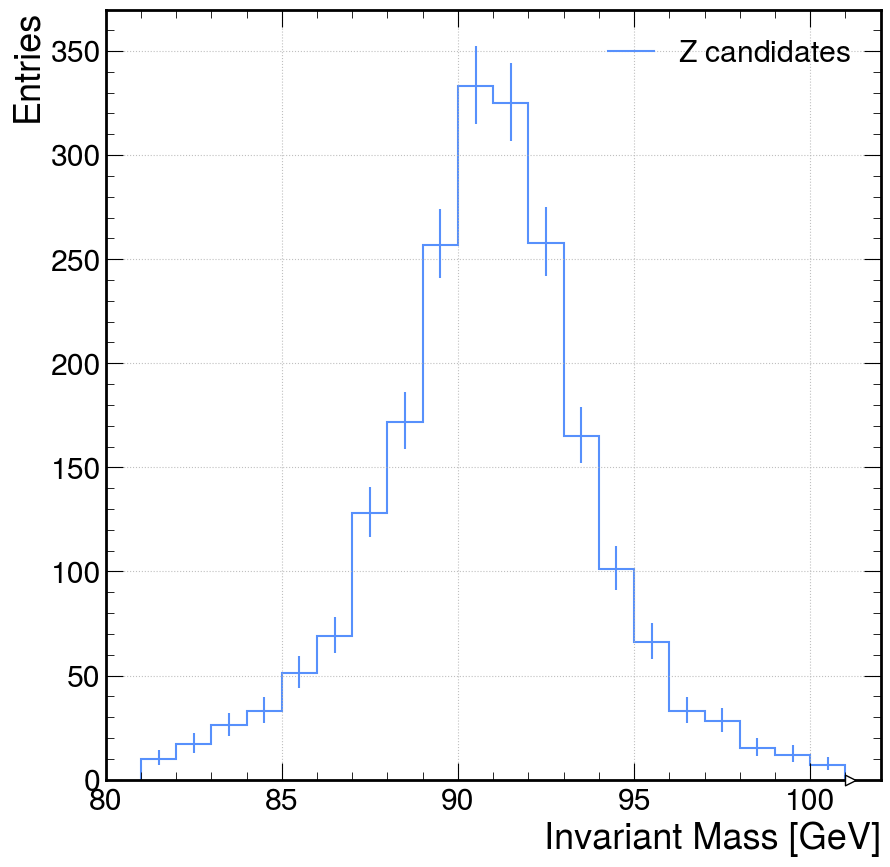

In [9]:
import numpy as np
import awkward as ak

from coffea.nanoevents import NanoEventsFactory
from coffea.nanoevents.schemas import DelphesSchema

# Analysis of H -> Z eta_c
filename = "../output/ggH_2HDM/delphes_output_HZetac.root"
events = NanoEventsFactory.from_root(filename, schemaclass=DelphesSchema).events()

# Jets (PT > 20 GeV and |Eta| < 2.5)
jets = events.Jet
jets = jets[(jets.PT > 20) & (abs(jets.Eta) < 2.5)]

# Electrons (PT > 18 GeV, |Eta| < 2.47)
electrons = events.Electron
electrons = electrons[(electrons.PT > 18) & (abs(electrons.Eta) < 2.47)]

# Muons (PT > 18 GeV, |Eta| < 2.7)
muons = events.Muon
muons = muons[(muons.PT > 18) & (abs(muons.Eta) < 2.7)]

# Select events with either 2 muons or 2 electrons that have opposite Charge by defining masks
mask_2mu = ak.num(muons) == 2
mask_2e = ak.num(electrons) == 2
mask_dilepton = (mask_2mu | mask_2e)

# Get dilepton pairs from electrons and muons
dileptons_muons = ak.combinations(muons, 2)
dileptons_electrons = ak.combinations(electrons, 2)
dileptons = ak.concatenate([dileptons_muons, dileptons_electrons], axis=1)

# Select dileptons with opposite charge and dilepton mass between 81 and 101 GeV
def check_z_candidates(dileptons, max_difference=10):
    opposite_charge = dileptons['0'].Charge != dileptons['1'].Charge
    mass = np.sqrt(2 * dileptons['0'].PT * dileptons['1'].PT * (np.cosh(dileptons['0'].Eta - dileptons['1'].Eta) - np.cos(dileptons['0'].Phi - dileptons['1'].Phi)))
    m_z = 91.1876
    mass_difference = np.abs(mass - m_z)

    return opposite_charge & (mass_difference < max_difference)

# Apply masks
mask_z_candidates = ak.any(check_z_candidates(dileptons), axis=1)
selection_mask = (mask_dilepton & mask_z_candidates)

events.eager_compute_divisions()
print(len(events))

selected_events = events[selection_mask]
selected_events.eager_compute_divisions()
print(len(selected_events))

## Event selection done, now we can plot the invariant mass of the selected dilepton system

jets = selected_events.Jet
jets = jets[(jets.PT > 20) & (abs(jets.Eta) < 2.5)]

electrons = selected_events.Electron
electrons = electrons[(electrons.PT > 18) & (abs(electrons.Eta) < 2.47)]

muons = selected_events.Muon
muons = muons[(muons.PT > 18) & (abs(muons.Eta) < 2.7)]

dileptons_muons = ak.combinations(muons, 2)
dileptons_electrons = ak.combinations(electrons, 2)
dileptons = ak.concatenate([dileptons_muons, dileptons_electrons], axis=1)

mass = np.sqrt(2 * dileptons['0'].PT * dileptons['1'].PT * (np.cosh(dileptons['0'].Eta - dileptons['1'].Eta) - np.cos(dileptons['0'].Phi - dileptons['1'].Phi)))
mass = ak.flatten(mass.compute()).to_numpy()

# Create a histogram object and fill it with the mass data
h = hist.Hist(
    hist.axis.Regular(20, 81, 101, name="Invariant Mass [GeV]", label='Z candidates')
)
h.fill(mass)

# Plot the invariant mass distribution using matplotlib and CMS style
hep.style.use(hep.style.CMS)
fig, ax = plt.subplots()
h.plot(ax=ax, histtype='step')
ax.legend([r'$Z$ candidates'])
ax.set_xlabel('Invariant Mass [GeV]')
ax.set_ylabel('Entries')
ax.grid(True)
plt.show()


In [79]:
import awkward as ak
import numpy as np

# Get jets and the truth-level particle collection.
jets = events.Jet           # Check that this is the correct branch name
truth_parts = events.Particle  # Or events.GenPart if that's what you use

# Use the correct field name (likely 'Particle.ref' instead of 'Particles.refs')
# This creates a new field "has_pdg36" that is True if any constituent truth particle has PDG id 36.
jets = ak.with_field(
    jets,
    ak.any(abs(truth_parts.PID[jets.Particles.refs]) == 36, axis=-1),
    "has_pdg36"
)

# Inspect the result.
print("Jets with a constituent PDG id 36:", jets.has_pdg36)
print("Number of jets with a PDG id 36 constituent:", int(np.sum(jets.has_pdg36)))


IndexError: cannot slice NumpyArray (of length ##) with [...]: too many jagged slice dimensions for array